In [1]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
import json
import re
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.decomposition import PCA

In [2]:
project_path = '/content/drive/MyDrive/Colab Notebooks/PatternMining'

# Load dataset

In [1]:
# file_path = f'{project_path}/datasets/all_video_games(cleaned).csv'
file_path = f'{project_path}/datasets/merged.csv'
data = pd.read_csv(file_path)

NameError: name 'project_path' is not defined

# PreProcess

In [89]:
# Set the allowable limit for missing values
allowable_limit = len(data) * 0.8  # You can adjust this threshold as per your preference

# Iterate over each column
for column in data.columns:
    # Count the missing values in each column
    missing_count = data[column].isnull().sum()

    # If missing values exceed the allowable limit, drop the column
    if missing_count > allowable_limit:
        data = data.drop(column, axis=1)
        print(f"Dropped column '{column}' due to exceeding allowable limit of missing values.")
    else:
        # For numerical columns, fill missing values with mean
        if data[column].dtype in ['int64', 'float64']:
            data.loc[:, column] = data[column].fillna(data[column].mean())
        else:
            data.loc[:, column] = data[column].fillna(data[column].mode()[0])


print("Missing values filled successfully.")
# print(data)


Dropped column 'jp_sales' due to exceeding allowable limit of missing values.
Missing values filled successfully.


# Manual preProcess

## Sales process

In [90]:
max_value = data['total_sales'].max()
min_value = data['total_sales'].min()
for column in ['total_sales', 'pal_sales', 'other_sales']:
    data[column] = (data[column] - min_value) / (max_value - min_value)
    # print(data[column])

In [91]:
data['other_sales'] = data['total_sales'] - data['pal_sales'] - data['na_sales']

## Platforms info process

In [92]:
def compute_max_metascore_info(informations):
    informations = informations.replace("'", '"')
    informations = json.loads(informations)
    max_metascore = 0
    max_metascore_count = 0
    for info in informations:
        pattern = r'\d+'

        metascore_count = 0
        metascore = 0

        if 'Platform Metascore Count' in info:
            match = re.search(pattern, info['Platform Metascore Count'])
            if match:
                metascore_count = int(match.group())

        if 'Platform Metascore' in info:
            match = re.search(pattern, info['Platform Metascore'])
            if match:
                metascore = int(match.group())

        if metascore_count > max_metascore_count:
            max_metascore_count = metascore_count
            max_metascore = metascore

    return max_metascore_count, max_metascore

In [93]:
# Apply the function to each row in the 'platforms info' column
max_metascore_info = data['platforms info'].apply(compute_max_metascore_info)

# Split the resulting tuples into separate columns
data[['max_metascore_count', 'max_metascore']] = pd.DataFrame(max_metascore_info.tolist(), index=data.index)

data.drop(columns=['platforms info'], inplace=True)
# Display the updated DataFrame
# print(data)

# Outlires

In [94]:
def remove_outliers(data, column):
  # Calculate the quantiles for Winsorization
  q1 = data[column].quantile(0.25)
  q3 = data[column].quantile(0.75)

  # Define the threshold for extreme values
  threshold = 1.5 * (q3 - q1)

  # Apply Winsorization
  data[column] = data[column].clip(lower=data[column].quantile(0.05), upper=data[column].quantile(0.95))
  return data

In [95]:
data = remove_outliers(data, 'na_sales')
data = remove_outliers(data, 'pal_sales')
data = remove_outliers(data, 'other_sales')
data = remove_outliers(data, 'max_metascore')
data = remove_outliers(data, 'max_metascore_count')

# Save dataset

In [96]:
data.to_csv(f'{project_path}/datasets/merged_cleaned.csv', index=False)

# Load Cleaned

In [4]:
data = pd.read_csv(f'{project_path}/datasets/merged_cleaned.csv')

In [15]:
data.drop(columns=['img', 'title', 'other_sales', 'release date_x', 'last_update', 'genres', 'genres splitted'], inplace=True)

In [6]:
# numeric_columns = ['critic_score', 'total_sales', 'na_sales', 'pal_sales', 'other_sales', 'user score', 'user ratings count', 'max_metascore_count', 'max_metascore']
numeric_columns = ['critic_score', 'total_sales', 'na_sales', 'pal_sales', 'user score', 'user ratings count', 'max_metascore_count', 'max_metascore']

for column in numeric_columns:
    data[column] = pd.cut(data[column], bins=3, labels=['low', 'medium', 'high'])

print(data.head())

  console   genre     publisher_x     developer_x critic_score total_sales  \
0     PS3  Action  Rockstar Games  Rockstar North         high        high   
1     PS4  Action  Rockstar Games  Rockstar North         high        high   
2    X360  Action  Rockstar Games  Rockstar North         high        high   
3    XOne  Action  Rockstar Games  Rockstar North         high      medium   
4      PC  Action  Rockstar Games  Rockstar North         high         low   

  na_sales pal_sales      product rating user score user ratings count  \
0     high      high  Rated M For Mature       high                low   
1     high      high  Rated M For Mature       high                low   
2     high      high  Rated M For Mature       high                low   
3     high      high  Rated M For Mature       high                low   
4   medium    medium  Rated M For Mature       high                low   

  max_metascore_count max_metascore  
0                high          high  
1         

In [7]:
# Convert categorical data to one-hot encoding
data_one_hot = pd.get_dummies(data)

# Display the one-hot encoded dataframe to check the changes
print(data_one_hot.head())


   console_2600  console_3DO  console_3DS  console_5200  console_7800  \
0         False        False        False         False         False   
1         False        False        False         False         False   
2         False        False        False         False         False   
3         False        False        False         False         False   
4         False        False        False         False         False   

   console_ACPC  console_AJ  console_All  console_Amig  console_And  ...  \
0         False       False        False         False        False  ...   
1         False       False        False         False        False  ...   
2         False       False        False         False        False  ...   
3         False       False        False         False        False  ...   
4         False       False        False         False        False  ...   

   user score_high  user ratings count_low  user ratings count_medium  \
0             True             

In [11]:
# Perform frequent pattern extraction using the apriori algorithm
min_support_threshold = 0.9
frequent_itemsets = apriori(data_one_hot, min_support=min_support_threshold, use_colnames=True)
print(frequent_itemsets)

    support                                           itemsets
0  0.917068                                (critic_score_high)
1  0.998121                                  (total_sales_low)
2  0.999952                           (user ratings count_low)
3  0.915237               (total_sales_low, critic_score_high)
4  0.917020        (user ratings count_low, critic_score_high)
5  0.998072          (total_sales_low, user ratings count_low)
6  0.915189  (total_sales_low, user ratings count_low, crit...


In [12]:
# Generate association rules with minimum confidence threshold
min_confidence_threshold = 0.9  # Adjust as per your dataset and requirements
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence_threshold)

# Display the rules
print(rules)

                                    antecedents  \
0                             (total_sales_low)   
1                           (critic_score_high)   
2                      (user ratings count_low)   
3                           (critic_score_high)   
4                             (total_sales_low)   
5                      (user ratings count_low)   
6     (user ratings count_low, total_sales_low)   
7          (total_sales_low, critic_score_high)   
8   (user ratings count_low, critic_score_high)   
9                             (total_sales_low)   
10                     (user ratings count_low)   
11                          (critic_score_high)   

                                    consequents  antecedent support  \
0                           (critic_score_high)            0.998121   
1                             (total_sales_low)            0.917068   
2                           (critic_score_high)            0.999952   
3                      (user ratings count_low)     

# Clustering

In [9]:
file_path = f'{project_path}/datasets/merged_cleaned.csv'
data = pd.read_csv(file_path)
# data.drop(columns=['img', 'title', 'other_sales', 'release date_x', 'last_update', 'genres', 'genres splitted'], inplace=True)
data.drop(columns=['img', 'genres', 'genres splitted'], inplace=True)

# Display the first few rows of the DataFrame
print(data.head())


                title console   genre     publisher_x     developer_x  \
0  Grand Theft Auto V     PS3  Action  Rockstar Games  Rockstar North   
1  Grand Theft Auto V     PS4  Action  Rockstar Games  Rockstar North   
2  Grand Theft Auto V    X360  Action  Rockstar Games  Rockstar North   
3  Grand Theft Auto V    XOne  Action  Rockstar Games  Rockstar North   
4  Grand Theft Auto V      PC  Action  Rockstar Games  Rockstar North   

   critic_score  total_sales  na_sales  pal_sales  other_sales release date_x  \
0      9.400000     1.000000  0.520000    0.01624    -0.485217     2013-09-17   
1      9.700000     0.954232  0.520000    0.01624    -0.485217     2014-11-18   
2      7.368743     0.780512  0.520000    0.01624    -0.485217     2013-09-17   
3      9.000000     0.429134  0.520000    0.01624    -0.485217     2014-11-18   
4      7.368743     0.025265  0.309307    0.00923    -0.293273     2015-04-14   

  last_update      product rating  user score  user ratings count  \
0  20

In [10]:
# Identify numerical and categorical columns
numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = data.select_dtypes(include=['object', 'category']).columns.tolist()

print("Numerical columns:", numerical_columns)
print("Categorical columns:", categorical_columns)


Numerical columns: ['critic_score', 'total_sales', 'na_sales', 'pal_sales', 'other_sales', 'user score', 'user ratings count', 'max_metascore_count', 'max_metascore']
Categorical columns: ['title', 'console', 'genre', 'publisher_x', 'developer_x', 'release date_x', 'last_update', 'product rating']


In [11]:
# One-hot encode categorical columns
data_encoded = pd.get_dummies(data, columns=categorical_columns)

# Display the first few rows of the encoded DataFrame
print(data_encoded.head())


   critic_score  total_sales  na_sales  pal_sales  other_sales  user score  \
0      9.400000     1.000000  0.520000    0.01624    -0.485217         8.4   
1      9.700000     0.954232  0.520000    0.01624    -0.485217         8.4   
2      7.368743     0.780512  0.520000    0.01624    -0.485217         8.4   
3      9.000000     0.429134  0.520000    0.01624    -0.485217         8.4   
4      7.368743     0.025265  0.309307    0.00923    -0.293273         8.4   

   user ratings count  max_metascore_count  max_metascore  title_#IDARB  ...  \
0              9576.0                   66             89         False  ...   
1              9576.0                   66             89         False  ...   
2              9576.0                   66             89         False  ...   
3              9576.0                   66             89         False  ...   
4              9576.0                   66             89         False  ...   

   last_update_2024-01-17  last_update_2024-01-20 

In [12]:
# Standardize the numerical data
scaler = StandardScaler()
scaled_numerical_data = scaler.fit_transform(data[numerical_columns])
scaled_numerical_df = pd.DataFrame(scaled_numerical_data, columns=numerical_columns)

# Concatenate scaled numerical data with encoded categorical data
processed_data = pd.concat([scaled_numerical_df, data_encoded.drop(columns=numerical_columns)], axis=1)

# Display the first few rows of the processed DataFrame
print(processed_data.head())


   critic_score   total_sales  na_sales  pal_sales  other_sales  user score  \
0  3.118629e+00  2.905503e+01  2.175593   2.180668    -2.124537    1.073274   
1  3.579226e+00  2.769078e+01  2.175593   2.180668    -2.124537    1.073274   
2  2.727277e-15  2.251250e+01  2.175593   2.180668    -2.124537    1.073274   
3  2.504501e+00  1.203858e+01  2.175593   2.180668    -2.124537    1.073274   
4  2.727277e-15  1.034177e-16  0.324074   0.360710    -0.323479    1.073274   

   user ratings count  max_metascore_count  max_metascore  title_#IDARB  ...  \
0            5.365814             1.659305       1.485977         False  ...   
1            5.365814             1.659305       1.485977         False  ...   
2            5.365814             1.659305       1.485977         False  ...   
3            5.365814             1.659305       1.485977         False  ...   
4            5.365814             1.659305       1.485977         False  ...   

   last_update_2024-01-17  last_update_2024-

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

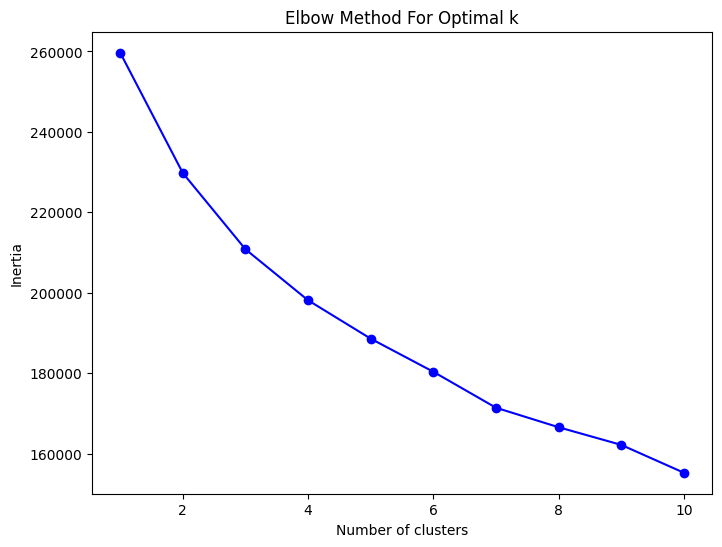

In [23]:
# Using the elbow method to find the optimal number of clusters
inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(processed_data)
    inertia.append(kmeans.inertia_)

# Plotting the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()


In [13]:
# Let's assume the optimal number of clusters found is 3
optimal_k = 3

# Apply k-means
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(processed_data)

# Add the cluster labels to the original DataFrame
data['Cluster'] = clusters

# Display the first few rows with cluster labels
print(data.head())


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


                title console   genre     publisher_x     developer_x  \
0  Grand Theft Auto V     PS3  Action  Rockstar Games  Rockstar North   
1  Grand Theft Auto V     PS4  Action  Rockstar Games  Rockstar North   
2  Grand Theft Auto V    X360  Action  Rockstar Games  Rockstar North   
3  Grand Theft Auto V    XOne  Action  Rockstar Games  Rockstar North   
4  Grand Theft Auto V      PC  Action  Rockstar Games  Rockstar North   

   critic_score  total_sales  na_sales  pal_sales  other_sales release date_x  \
0      9.400000     1.000000  0.520000    0.01624    -0.485217     2013-09-17   
1      9.700000     0.954232  0.520000    0.01624    -0.485217     2014-11-18   
2      7.368743     0.780512  0.520000    0.01624    -0.485217     2013-09-17   
3      9.000000     0.429134  0.520000    0.01624    -0.485217     2014-11-18   
4      7.368743     0.025265  0.309307    0.00923    -0.293273     2015-04-14   

  last_update      product rating  user score  user ratings count  \
0  20

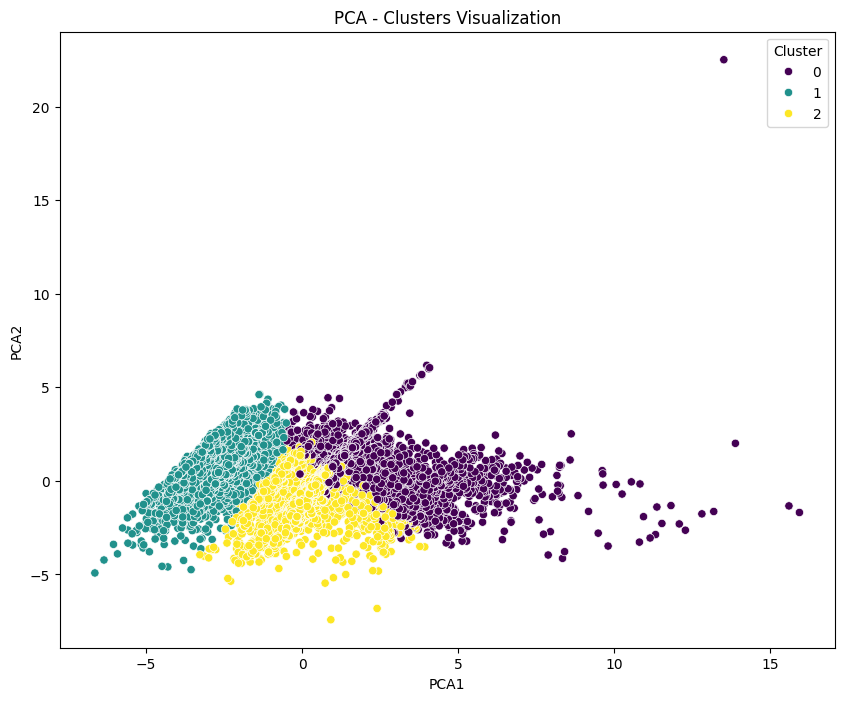

In [14]:
# Reduce dimensions with PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(processed_data)
pca_df = pd.DataFrame(data=pca_result, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = clusters

# Visualize the PCA-reduced data
plt.figure(figsize=(10, 8))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Cluster', palette='viridis')
plt.title('PCA - Clusters Visualization')
plt.show()
